# CS342 Final Project
### Dayou Ren; Spencer Petty
### dr37269; sap3758

In this project, we will be building and training an autoencoder architecture to generate images of CS professor. We are basically asking this question: "what does a neural network believe a CS professor should look like?"

In [1]:
import cv2
from PIL import Image
import numpy as np

# Define the desired dimensions for the cropped and resized images
crop_size = (500, 500)

# Open each headshot image and crop it to the desired size
for i in range(1, 6):
    # Replace 'image_path' with the actual file path of the image
    image_path = f'./CS_prof_images/image_{i}.jpg'
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect all the faces in the image
    faces = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml").detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3)

    # Crop the image based on the location of the first detected face
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_image = gray[y:y+h, x:x+w]

        # Resize the cropped image to the desired dimensions
        resized_img = cv2.resize(face_image, crop_size)

        # Convert the resized image to RGB
        rgb_resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

        # Save the resized image with the original file name
        output_path = f'./cropped_CS_prof_images/resized_image_{i}.jpg'
        Image.fromarray(rgb_resized_img).save(output_path)
    else:
        print(f"No face detected in image {i}. Skipping.")


# Variational Autoencoder Class

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt


In [3]:
image_size = crop_size[0] * crop_size[1] * 3

print(image_size)
# Note that, for right now, this is not vanilla autoencoder, as opposed to the variational version
class VAE(nn.Module):
    def __init__(self, latent_dims, hidden_nodes):
        super().__init__()
        self.encode = torch.nn.Sequential(
            torch.nn.Linear(in_features = image_size, out_features = hidden_nodes),
            nn.ReLU(),
            torch.nn.Linear(hidden_nodes, latent_dims)
        )

        self.decode = torch.nn.Sequential(
        torch.nn.Linear(latent_dims, hidden_nodes),
        nn.ReLU(),
        torch.nn.Linear(hidden_nodes, image_size),
        nn.Sigmoid()
        )

    def forward(self, x):
        z = torch.flatten(x)
        z = self.encode(z)
        x_hat = self.decode(z)
        return torch.reshape(x_hat, (crop_size[0], crop_size[1], -1))

750000


In [4]:
# Test the syntax and dimensionality of the model on a few samples. Expect noise as output
def test_noise_generation():
    model = VAE(10, 1028)
    for i in range(1, 6):
        image_path = f'./cropped_CS_prof_images/resized_image_{i}.jpg'
        img = torch.tensor(cv2.imread(image_path), dtype = torch.float32)
        out = model(img)
        plt.matshow(out.squeeze().detach())

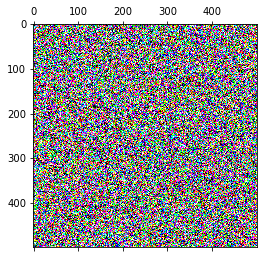

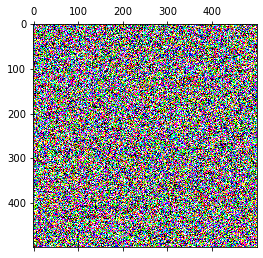

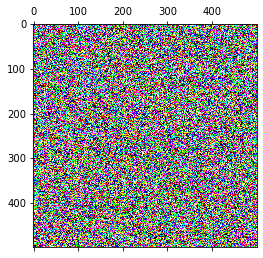

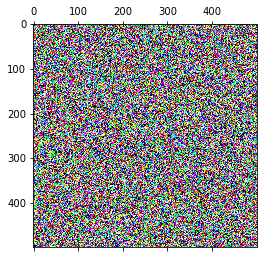

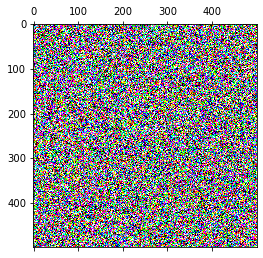

In [5]:
test_noise_generation()

In [ ]:
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size), x.view(-1, image_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

